In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [146]:
input_path = "data_v2/step2/"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
#         transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
#         transforms.GaussianBlur(kernel_size=3),
        
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + 'valid', data_transforms['validation']),
    'test':
    datasets.ImageFolder(input_path + 'test', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0),  # for Kaggle,
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
    							batch_size=32,
    							shuffle=False,
    							num_workers=0)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2))

state_dict = torch.load('models/pytorch/data_v2_step1.pth')
model.load_state_dict(state_dict)
model.to(device)

for param in model.parameters():
    param.requires_grad = True   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

/home/lrx/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/lrx/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [147]:
num_epochs = 20
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)

    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                    epoch_loss,
                                                    epoch_acc))


test_corrects = 0
y, predictions = [], []
model.eval()
for inputs, labels in dataloaders['test']:
    y.append(labels.cpu().numpy())
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
    predictions.append(preds.cpu().numpy())
    test_corrects += torch.sum(preds == labels.data)

test_acc = running_corrects.double() / len(image_datasets['test'])
print('test acc: {:.4f}'.format(test_acc))

# !mkdir models
# !mkdir models/pytorch

# torch.save(model, 'models/pytorch/data_v2_step2.pth')

Epoch 1/20
----------
train loss: 0.5638, acc: 0.7126
validation loss: 0.4820, acc: 0.7737
Epoch 2/20
----------
train loss: 0.4261, acc: 0.8002
validation loss: 0.4406, acc: 0.8759
Epoch 3/20
----------
train loss: 0.3828, acc: 0.8386
validation loss: 0.2828, acc: 0.8978
Epoch 4/20
----------
train loss: 0.3776, acc: 0.8435
validation loss: 0.2906, acc: 0.8759
Epoch 5/20
----------
train loss: 0.3452, acc: 0.8445
validation loss: 0.2467, acc: 0.8686
Epoch 6/20
----------
train loss: 0.3213, acc: 0.8730
validation loss: 0.2201, acc: 0.8905
Epoch 7/20
----------
train loss: 0.2941, acc: 0.8740
validation loss: 0.2740, acc: 0.8467
Epoch 8/20
----------
train loss: 0.2777, acc: 0.8917
validation loss: 0.1554, acc: 0.9489
Epoch 9/20
----------
train loss: 0.2336, acc: 0.8986
validation loss: 0.3416, acc: 0.8613
Epoch 10/20
----------
train loss: 0.2484, acc: 0.9144
validation loss: 0.1321, acc: 0.9489
Epoch 11/20
----------
train loss: 0.2361, acc: 0.9114
validation loss: 0.4489, acc: 0.83

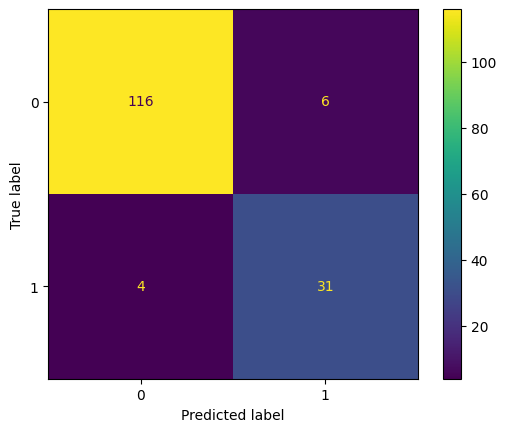

In [144]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

y = [item for sublist in y for item in sublist]
predictions = [item for sublist in predictions for item in sublist]
y = np.asarray(y)
predictions = np.asarray(predictions)
cm = confusion_matrix(y, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.savefig('data_v2_step2.png')

In [145]:
from sklearn.metrics import f1_score
f1_score(y, predictions, average='macro')

0.9098943985307621

In [127]:
torch.save(model.state_dict(), 'models/pytorch/data_v2_step1.pth')